In [1]:
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

In [2]:
%%time
# Read Json
raw_data = pd.read_json('./realties.json', lines=True)
df = pd.read_json('./realties.json', lines=False)
df_src = json_normalize(data=df['_source'])

del raw_data
del df

CPU times: user 1min 13s, sys: 1min 10s, total: 2min 24s
Wall time: 2min 48s


In [3]:
%%time
## Select columns by follow Data Sprints Doc ##
null_col = df_src.columns[df_src.isna().sum() > 100000]
df_selected = df_src.drop(null_col, axis=1)

del null_col
del df_src

CPU times: user 1 s, sys: 56.9 ms, total: 1.06 s
Wall time: 896 ms


/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Value Distribution - Before Cut Outlier')

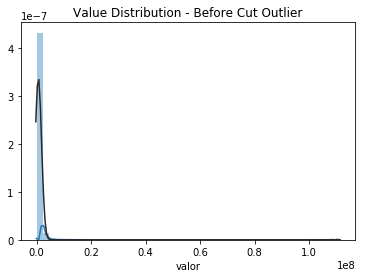

In [6]:
## Plot Value Distribution
sns.distplot(df_selected['valor'].dropna(), fit=norm).set_title("Value Distribution - Before Cut Outlier")

# Wrangling

In [9]:
## Translate Columns Name ##
df_selected.rename(columns={"anunciante.id": "advertiser.id", \
                            "anunciante.nome": "advertiser.name", \
                            "bairro.id": "neighborhood.id", \
                            "bairro.nome": "neighborhood.name", \
                            "banheiro": "bathroom", \
                            "cidade.full_name": "city.full_name", \
                            "cidade.short_name": "city.short_name", \
                            "cidade_uf": "city_uf", \
                            "codigo": "code", \
                            "condominio": "condominium", \
                            "data_inclusao": "date_inclusion", \
                            "descricao": "description", \
                            "endereco": "address", \
                            "tipo_negocio": "business_type", \
                            "garagem": "garage", \
                            "lista_fotos": "photolist", \
                            "opcionais": "optional", \
                            "quarto": "bedroom", \
                            "tipo_imovel": "property_type", \
                            "valor": "value", \
                            "zoneamento.id": "zoning.id", \
                            "zoneamento.nome": "zoning.name", \
                            "zoneamento.sigla": "zoning.initials", \
                            "finalidade": "goal"
                           }, inplace=True)

df_selected['property_type'] = df_selected['property_type'].apply(lambda x: sorted(x)).apply(' ,'.join)

In [6]:
df_selected['property_type'].apply(lambda x: x[0]).unique()

array(['Casa', 'Sobrado', 'Apartamento', 'Quarto', 'Residencia',
       'Terreno', 'Conjunto', 'Garagem', 'Loja', 'Cobertura', 'Duplex',
       'Prédio', 'Galpão', 'Sala', 'Andar', 'Garden', 'Industrial',
       'Loft', 'Pousada', 'Sítio', 'Kitnet', 'Studio', 'Flat', 'Ponto',
       'Sobreloja', 'Triplex', 'Clínica', 'Chácara', 'República',
       'Fazenda', 'Edícula', 'Box', 'Coworking', 'Chalé', 'Resort',
       'Haras', 'Geminado'], dtype=object)

In [72]:
df_selected['property_type'].apply(' ,'.join).unique().shape

(801,)

default
error** -> have some dict
goal** -> name swap place
geometry.coordinates** -> float found
photolist
optional** -> have some dict, use json_normalize to extract
motion_type** -> name swap place

# Duplicate Alert

1. Who duplicate the data?
    A. Popular Advertiser -> advertiser.name?
    B. Third Company -> 
    C. The Company Crawler
2. What do these duplicate ads contain? -> Drop it
3. When are ads duplicated?
4. What happens to duplication, and where(which columns) is in stored?
5. Why are the duplicated?

In [ ]:
df_selected['advertiser.name'].unique().shape

In [ ]:
df_selected['scraping.spider_name'].unique().shape

- Popular Advertiser = advertiser.name
- Third Company = 
- The Company Crawler = scraping.spider_name

### Find Top 20 Advertiser

In [341]:
# df_selected.groupby(['advertiser.name'], as_index=True)['advertiser.name'].count()
top_ads = df_selected['advertiser.name'].value_counts()

[Text(0.5, 0, 'ads count')]

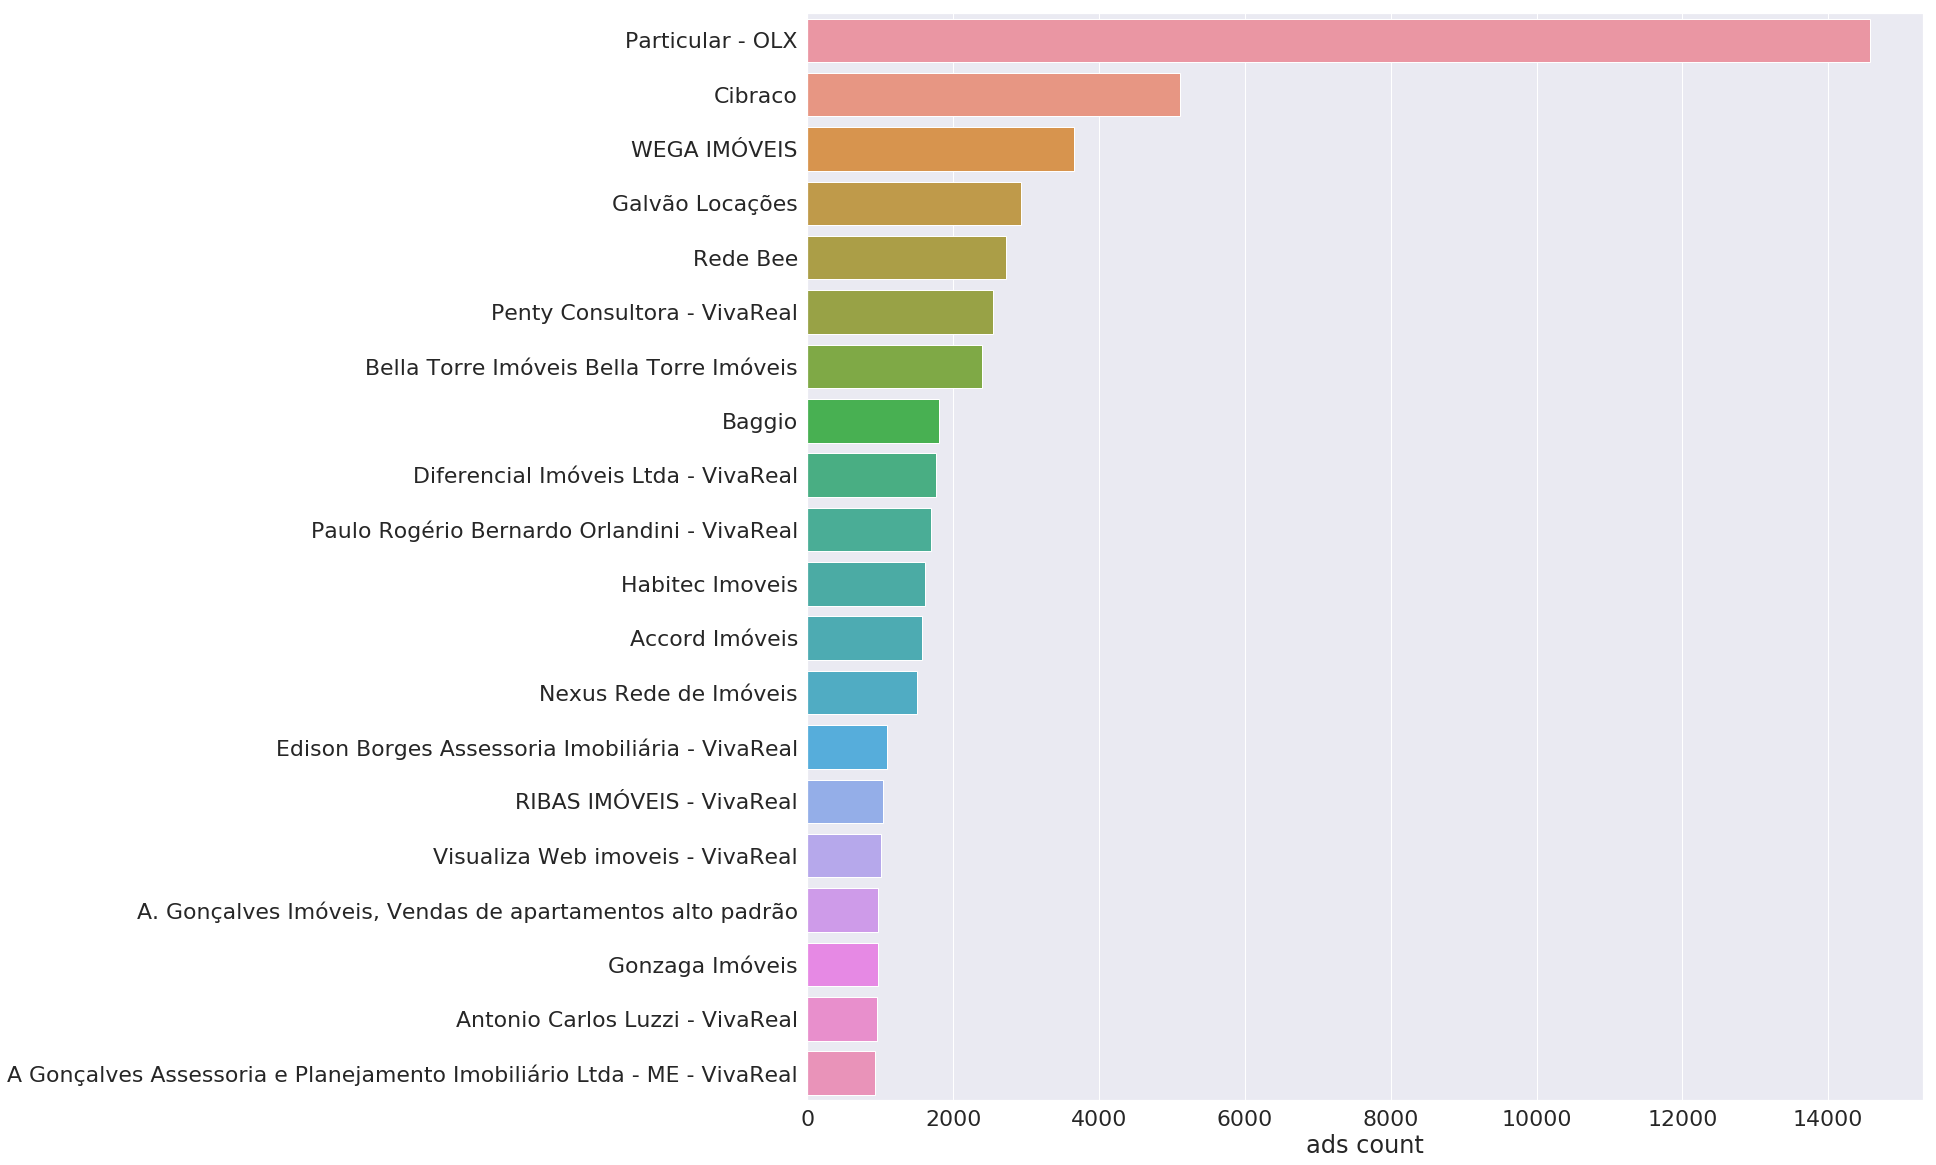

In [342]:
plt.figure(figsize=(20, 20))
sns.set(font_scale=2)
ax = sns.barplot(y=top_ads.index[:20], x=top_ads.head(20))
ax.set(xlabel='ads count')

In [8]:
## Popular Advertiser
top_ads.index[top_ads.values > 50].shape

(475,)

In [10]:
## Third Company
top_ads.index[top_ads.values <= 50].shape

(1107,)

In [11]:
df_selected.isnull().sum()

advertiser.id            1591
advertiser.name          1591
area_total              43776
area_util               28606
neighborhood.id          1148
neighborhood.name        1148
bathroom                38243
city.full_name              0
city.short_name             0
city_uf                     0
code                    84922
condominium             40432
date_inclusion              0
default                     0
description                 0
address                 30348
error                       0
goal                        0
garage                  21169
geohash                 30375
geometry.coordinates    30375
geometry.type           30375
iptu                    53726
isparticular                0
isportal                    0
latitude                30336
photolist                4461
longitude               30336
optional                    0
bedroom                 13090
scraping.spider_name        0
status                      0
suite                   54175
property_t

In [11]:
df_ddp = df_selected.drop_duplicates(['title'], keep='first')

### What Top Advertiser Advertise

In [632]:
top_ads.index[0:10]

Index(['Particular - OLX', 'Cibraco', 'WEGA IMÓVEIS', 'Galvão Locações',
       'Rede Bee', 'Penty Consultora - VivaReal',
       'Bella Torre Imóveis Bella Torre Imóveis', 'Baggio',
       'Diferencial Imóveis Ltda - VivaReal',
       'Paulo Rogério Bernardo Orlandini - VivaReal'],
      dtype='object')

In [552]:
gp_prop_type = df_ddp.groupby(['main_property_type'], as_index=False).count()

In [547]:
top_ads_cat = df_selected.groupby(['advertiser.name'], as_index=False).count()

In [616]:
test = df_ddp[df_ddp['advertiser.name'] == '7imóveis - VivaReal']
test['main_property_type'].value_counts()

Apartamento    455
Casa            94
Cobertura       34
Quarto          26
Studio          15
Sobrado         14
Sala            10
Garden           5
Residencia       5
Duplex           5
Andar            5
Terreno          3
Garagem          2
Loft             1
Prédio           1
Name: main_property_type, dtype: int64

In [630]:
frame = {}
for name in df_ddp.main_property_type.unique():
    test = pd.Series(df_ddp[df_ddp['main_property_type'] == name].groupby(['advertiser.name']).count()['main_property_type'])
    frame[name] = test
    
result = pd.DataFrame(frame)
result = result.reset_index()
result = result.rename(columns={'index':'advertiser.name'}).fillna(0)

In [645]:
result[result['advertiser.name']=='Particular - OLX']

,advertiser.name,Andar,Apartamento,Box,Casa,Chácara,Clínica,Cobertura,Conjunto,Coworking,...,Quarto,República,Residencia,Resort,Sala,Sobrado,Studio,Sítio,Terreno,Triplex
900,Particular - OLX,0.0,8443.0,0.0,6122.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [643]:
top_ads.index[0:10]

Index(['Particular - OLX', 'Cibraco', 'WEGA IMÓVEIS', 'Galvão Locações',
       'Rede Bee', 'Penty Consultora - VivaReal',
       'Bella Torre Imóveis Bella Torre Imóveis', 'Baggio',
       'Diferencial Imóveis Ltda - VivaReal',
       'Paulo Rogério Bernardo Orlandini - VivaReal'],
      dtype='object')

In [673]:
df_ddp['main_property_type'].unique()

array(['Casa', 'Sobrado', 'Apartamento', 'Quarto', 'Residencia',
       'Conjunto', 'Loja', 'Cobertura', 'Terreno', 'Industrial', 'Sala',
       'Galpão', 'Garagem', 'Prédio', 'Andar', 'Garden', 'Pousada',
       'Kitnet', 'Studio', 'Ponto', 'Triplex', 'Clínica', 'Duplex',
       'Chácara', 'Box', 'Sítio', 'Fazenda', 'Edícula', 'Flat', 'Loft',
       'República', 'Coworking', 'Resort', 'Geminado'], dtype=object)

In [649]:
filter_list = list(top_ads.index[0:10])
result = result[result['advertiser.name'].isin(filter_list)]

In [651]:
result_mean = result.mean()
result_std = result.std()

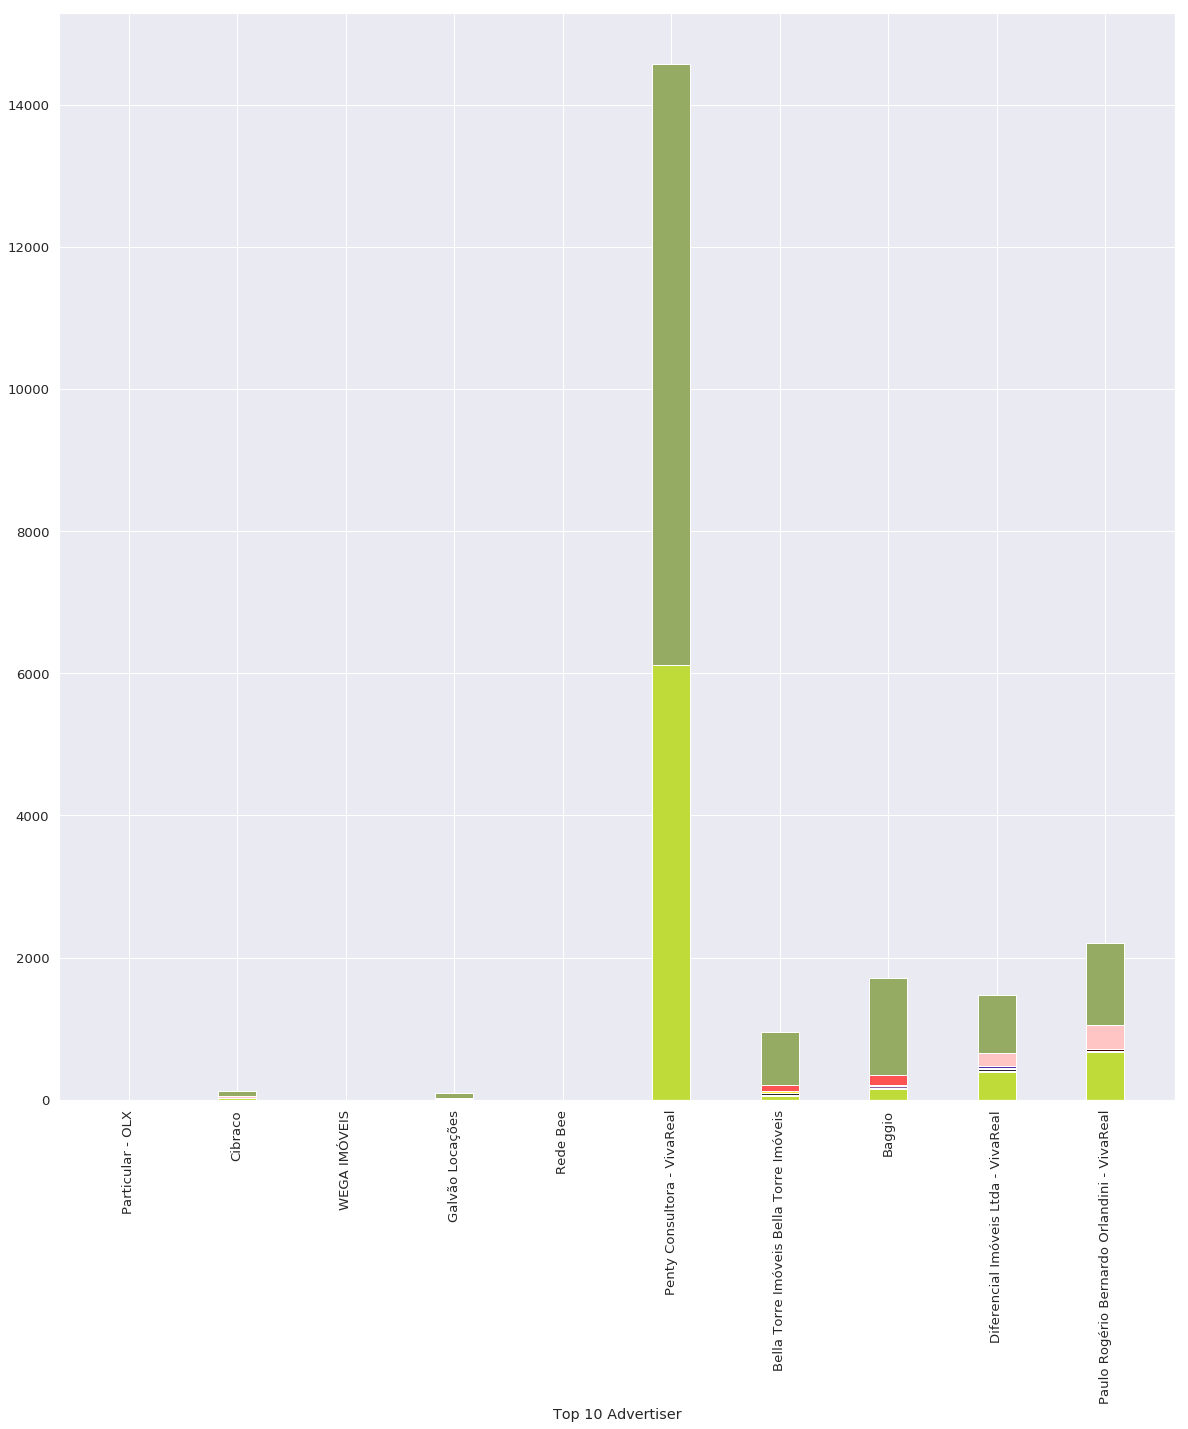

In [674]:
N = 10
ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots(figsize=(20, 20))
ax = plt.bar(ind, result['Casa'], color='#BEDB39', width=width)
ax = plt.bar(ind, result['Sobrado'], bottom=result['Casa'], color='#BDD684', width=width)
ax = plt.bar(ind, result['Apartamento'], bottom=result['Casa'], color='#95AB63', width=width)
ax = plt.bar(ind, result['Quarto'], bottom=result['Casa'], color='#67CC8E', width=width)
ax = plt.bar(ind, result['Residencia'], bottom=result['Casa'], color='#04BFBF', width=width)
ax = plt.bar(ind, result['Conjunto'], bottom=result['Casa'], color='#0EEAFF', width=width)
ax = plt.bar(ind, result['Loja'], bottom=result['Casa'], color='#0092B2', width=width)
ax = plt.bar(ind, result['Cobertura'], bottom=result['Casa'], color='#ff5252', width=width)
ax = plt.bar(ind, result['Terreno'], bottom=result['Casa'], color='#ffc5c5', width=width)
ax = plt.bar(ind, result['Industrial'], bottom=result['Casa'], color='#FF6600', width=width)
ax = plt.bar(ind, result['Sala'], bottom=result['Casa'], color='#512DA8', width=width)
ax = plt.bar(ind, result['Galpão'], bottom=result['Casa'], color='#AB47BC', width=width)
ax = plt.bar(ind, result['Garagem'], bottom=result['Casa'], color='#8B63A6', width=width)
ax = plt.bar(ind, result['Prédio'], bottom=result['Casa'], color='#607D8B', width=width)
ax = plt.bar(ind, result['Andar'], bottom=result['Casa'], color='#FFEB3B', width=width)
ax = plt.bar(ind, result['Garden'], bottom=result['Casa'], color='#BFBFBF', width=width)
ax = plt.bar(ind, result['Pousada'], bottom=result['Casa'], color='#454545', width=width)
ax = plt.bar(ind, result['Kitnet'], bottom=result['Casa'], color='#440505', width=width)
ax = plt.bar(ind, result['Studio'], bottom=result['Casa'], color='#2A2C2B', width=width)
ax = plt.bar(ind, result['Ponto'], bottom=result['Casa'], color='#F2B705', width=width)
ax = plt.bar(ind, result['Triplex'], bottom=result['Casa'], color='#8B63A6', width=width)
ax = plt.bar(ind, result['Clínica'], bottom=result['Casa'], color='#0092B2', width=width)
ax = plt.bar(ind, result['Duplex'], bottom=result['Casa'], color='#0092B2', width=width)
ax = plt.bar(ind, result['Chácara'], bottom=result['Casa'], color='#0092B2', width=width)
ax = plt.bar(ind, result['Box'], bottom=result['Casa'], color='#0092B2', width=width)
ax = plt.bar(ind, result['Sítio'], bottom=result['Casa'], color='#0092B2', width=width)
ax = plt.bar(ind, result['Fazenda'], bottom=result['Casa'], color='#0092B2', width=width)
ax = plt.bar(ind, result['Edícula'], bottom=result['Casa'], color='#0092B2', width=width)
ax = plt.bar(ind, result['Flat'], bottom=result['Casa'], color='#0092B2', width=width)
ax = plt.bar(ind, result['Loft'], bottom=result['Casa'], color='#0092B2', width=width)
ax = plt.bar(ind, result['República'], bottom=result['Casa'], color='#0092B2', width=width)
ax = plt.bar(ind, result['Coworking'], bottom=result['Casa'], color='#0092B2', width=width)
ax = plt.bar(ind, result['Resort'], bottom=result['Casa'], color='#0092B2', width=width)
ax = plt.bar(ind, result['Geminado'], bottom=result['Casa'], color='#0092B2', width=width)


plt.xticks(ind, list(top_ads.index[0:10]), rotation=90)
plt.xlabel('Top 10 Advertiser')
plt.show()


# Deal with value outlier

1. What types of interesting outliers can be identified?
    - What rule should we use to remove or maintain outlier? -> See distibution with z-score

df_ddp['z_value'] = np.abs((df_ddp['value'] - df_ddp['value'].mean())/df_ddp['value'].std(ddof=0))

df_wo = df_ddp[df_ddp['z_value'] < 1]

In [9]:
df_sell = df_ddp[df_ddp['business_type'] == 'Venda']
df_rent = df_ddp[df_ddp['business_type'] == 'Locação']

Text(0.5, 1.0, 'Value Distribution - Rent')

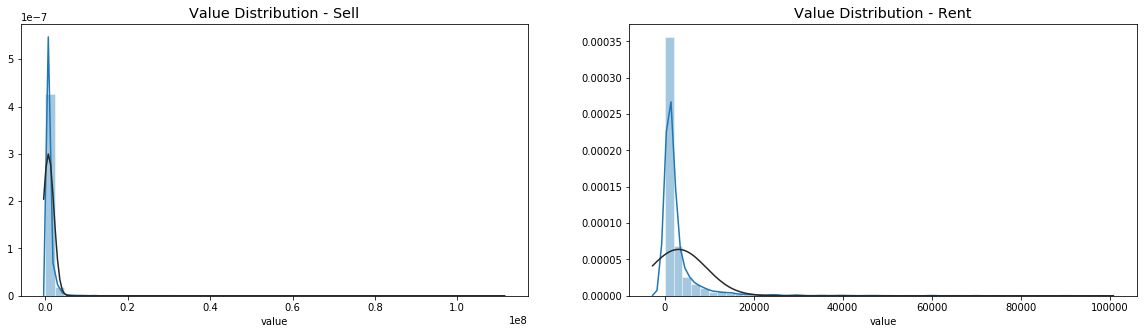

In [10]:
#[df_sell['value']<0.5*1e7]
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.set(font_scale=1.2)
sns.distplot(df_sell['value'].dropna(), fit=norm, ax=ax[0]).set_title("Value Distribution - Sell")
sns.distplot(df_rent['value'].dropna(), fit=norm, ax=ax[1]).set_title("Value Distribution - Rent")

In [11]:
df_sell['z_value'] = np.abs((df_sell['value'] - df_sell['value'].mean())/df_sell['value'].std(ddof=0))
df_wo_sell = df_sell[df_sell['z_value'] < 1]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
df_rent['z_value'] = np.abs((df_rent['value'] - df_rent['value'].mean())/df_rent['value'].std(ddof=0))
df_wo_rent = df_rent[df_rent['z_value'] < 1]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Value Distribution - Rent')

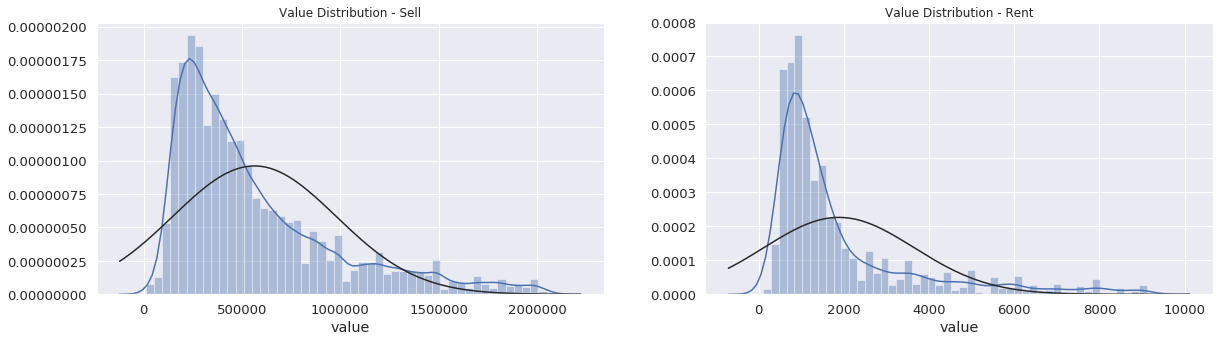

In [13]:
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.set(font_scale=1.0)
sns.distplot(df_wo_sell['value'].dropna(), fit=norm, ax=ax[0]).set_title("Value Distribution - Sell")
sns.distplot(df_wo_rent['value'].dropna(), fit=norm, ax=ax[1]).set_title("Value Distribution - Rent")

# Property Type Analysis

In [345]:
%%time
## Property_type filter 
j = 0
for i in range(df_selected.shape[0]):
    if(len(df_selected['property_type'][i])) > 2:
        j += 1
    else:
        continue
print(j)

4296
CPU times: user 3.35 s, sys: 0 ns, total: 3.35 s
Wall time: 3.35 s


In [551]:
df_ddp['main_property_type'] = df_ddp['property_type'].apply(lambda x: sorted(x)).apply(lambda x: [x[0]]).apply(' ,'.join)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [348]:
df_ddp['main_property_type'].value_counts()

Apartamento                               34608
Casa                                      14951
Sobrado                                    6837
Terreno                                    4748
Apartamento ,Quarto                        4605
Apartamento ,Residencia                    2427
Sala                                       2206
Cobertura                                  1706
Loja                                       1422
Conjunto                                   1010
Studio                                      920
Casa ,Residencia                            876
Residencia ,Terreno                         839
Quarto ,Sobrado                             787
Residencia ,Sobrado                         766
Residencia                                  664
Casa ,Quarto                                510
Prédio                                      503
Quarto                                      500
Galpão                                      492
Apartamento ,Garagem                    

[Text(0.5, 0, 'ads count')]

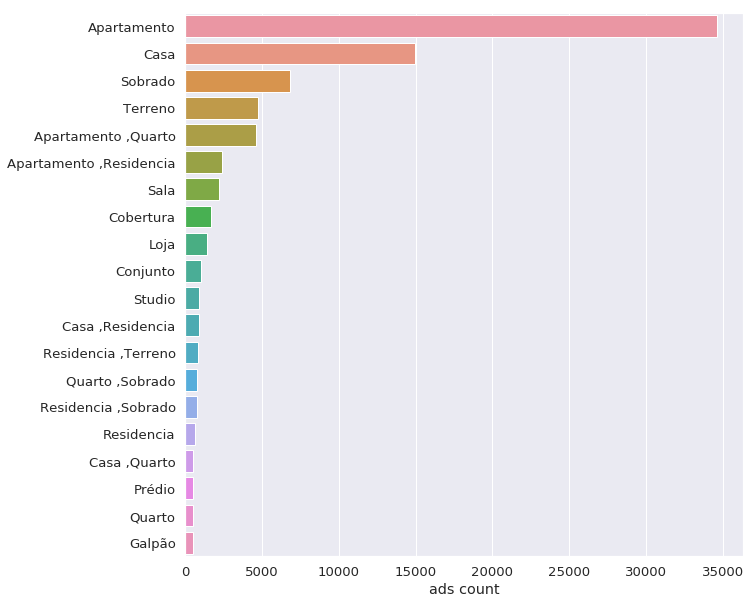

In [349]:
top_prop_type = df_ddp['main_property_type'].value_counts()
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)
ax = sns.barplot(y=top_prop_type.index[:20], x=top_prop_type.head(20))
ax.set(xlabel='ads count')

# Explore Geometry

### Cut Outlier Latitude Longitude

In [20]:
df_ddp.columns

Index(['advertiser.id', 'advertiser.name', 'area_total', 'area_util',
       'neighborhood.id', 'neighborhood.name', 'bathroom', 'city.full_name',
       'city.short_name', 'city_uf', 'code', 'condominium', 'date_inclusion',
       'default', 'description', 'address', 'error', 'goal', 'garage',
       'geohash', 'geometry.coordinates', 'geometry.type', 'iptu',
       'isparticular', 'isportal', 'latitude', 'photolist', 'longitude',
       'optional', 'bedroom', 'scraping.spider_name', 'status', 'suite',
       'property_type', 'business_type', 'title', 'uf', 'url', 'value',
       'zoning.id', 'zoning.name', 'zoning.initials', 'main_property_type'],
      dtype='object')

In [22]:
df_dna_geo.shape

(68702, 43)

In [23]:
df_lat = df_dna_geo['geometry.coordinates'].map(lambda x: x[0])
df_dna_geo['z_value_lat'] = np.abs((df_lat - df_lat.mean())/df_lat.std(ddof=0))
df_dna_geo = df_dna_geo[df_dna_geo['z_value_lat'] < 1]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
df_long = df_dna_geo['geometry.coordinates'].map(lambda x: x[1])
df_dna_geo['z_value_long'] = np.abs((df_long - df_long.mean())/df_long.std(ddof=0))
df_dna_geo = df_dna_geo[df_dna_geo['z_value_long'] < 1]

In [25]:
df_dna_geo.shape

(62377, 45)

In [26]:
df_dna_geo.columns

Index(['advertiser.id', 'advertiser.name', 'area_total', 'area_util',
       'neighborhood.id', 'neighborhood.name', 'bathroom', 'city.full_name',
       'city.short_name', 'city_uf', 'code', 'condominium', 'date_inclusion',
       'default', 'description', 'address', 'error', 'goal', 'garage',
       'geohash', 'geometry.coordinates', 'geometry.type', 'iptu',
       'isparticular', 'isportal', 'latitude', 'photolist', 'longitude',
       'optional', 'bedroom', 'scraping.spider_name', 'status', 'suite',
       'property_type', 'business_type', 'title', 'uf', 'url', 'value',
       'zoning.id', 'zoning.name', 'zoning.initials', 'main_property_type',
       'z_value_lat', 'z_value_long'],
      dtype='object')

Text(0.5, 1.0, 'Value Distribution - After Cut Outlier')

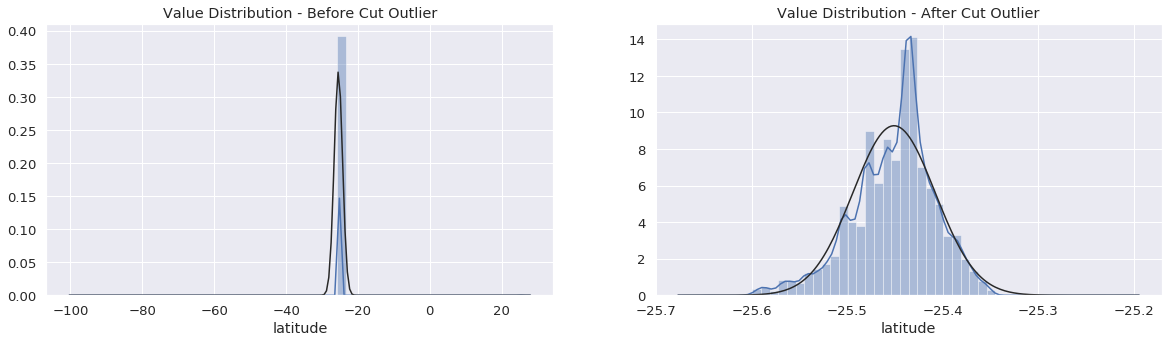

In [27]:
## Plot Value Distribution
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.distplot(df_selected['latitude'].dropna(), fit=norm, ax=ax[0]).set_title("Value Distribution - Before Cut Outlier")
sns.distplot(df_dna_geo['latitude'], fit=norm, ax=ax[1]).set_title("Value Distribution - After Cut Outlier")

Text(0.5, 1.0, 'Value Distribution - After Cut Outlier')

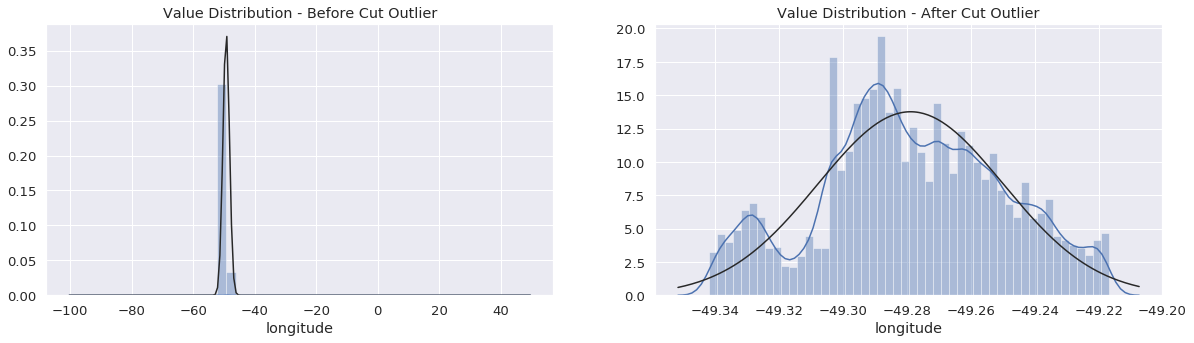

In [28]:
## Plot Value Distribution
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.distplot(df_selected['longitude'].dropna(), fit=norm, ax=ax[0]).set_title("Value Distribution - Before Cut Outlier")
sns.distplot(df_dna_geo['longitude'], fit=norm, ax=ax[1]).set_title("Value Distribution - After Cut Outlier")

In [29]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

#### https://geo.nyu.edu/catalog/stanford-vx469jv8459
sf_path = "./geo/Brazil-Curitiba/41MEE250GC_SIR.shp"
sf = gpd.read_file(sf_path, encoding='utf-8')
curi_sf = sf[sf.NM_MESO == 'METROPOLITANA DE CURITIBA']
curi_shape = curi_sf.to_crs({'init':'epsg:4326'})

#### https://download.geofabrik.de/south-america/brazil.html
roads_path = './geo/Brazil-Curitiba-Road/gis_osm_roads_free_1.shp'
road = gpd.read_file(roads_path, encoding='utf-8')

### Don't Forget to talk about encoding 'utf-8'

In [30]:
# http://ippuc.org.br/geodownloads/geo.htm
nbh_border_path = './geo/realties/DIVISA_DE_BAIRROS.shp'
nbh_border = gpd.read_file(nbh_border_path)
nbh_border_shape = nbh_border.to_crs({'init':'epsg:4326'})

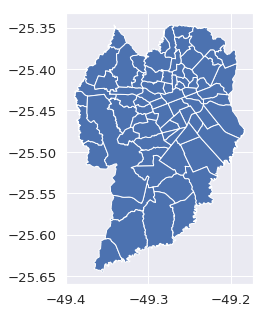

In [31]:
nbh_border_shape.plot(figsize=(5, 5))

### Convert Geo to work with Geopandas

In [32]:
geometry = [Point(xy) for xy in zip(df_dna_geo['geometry.coordinates'].map(lambda x: x[0]), df_dna_geo['geometry.coordinates'].map(lambda x: x[1]))]

In [33]:
df_dna_geo = gpd.GeoDataFrame(df_dna_geo, crs={'init':'epsg:4326'}, geometry=geometry)

In [34]:
# http://ippuc.org.br/geodownloads/geo.htm
zone_path = './geo/Brazil-Curitiba-Zone-SAD69_CWB/ZONEAMENTO.shp'
zone = gpd.read_file(zone_path)
zone_shape = zone.to_crs({'init':'epsg:4326'})

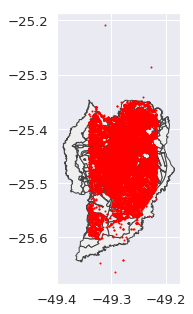

In [35]:
ax = zone_shape.plot(figsize=(5, 5), color='#EFEFEF', edgecolor='#444444')
df_dna_geo.plot(ax=ax, color='red', markersize=1)

In [82]:
union_nbh = gpd.sjoin(nbh_border_shape, df_dna_geo, op='intersects')

CPU times: user 29.3 s, sys: 408 ms, total: 29.7 s
Wall time: 29.4 s


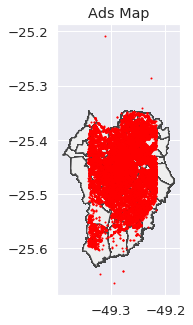

In [85]:
%%time
ax = union_nbh.plot(figsize=(5, 5), color='#EFEFEF', edgecolor='#444444')
df_dna_geo.plot(ax=ax, color='red', markersize=1)
plt.title('Ads Map')

In [39]:
df_ddp['zoning.initials'].unique()

array(['APA-PASSAÚNA', 'SEHIS', 'ZR-1', 'SE', 'ZT-LV', 'ZR-4', nan,
       'ZR-2', 'SE-NC', 'ZC', 'ZR-B', 'ZR-3', 'ZR-P', 'CONEC-4', 'SE-CC',
       'ZR-OC', 'ZT-MF', 'ZT-NC', 'ZR-SF', 'SE-LV', 'SH', 'PÓLO-LV',
       'SE-OI', 'SE-MF', 'ZI', 'ZS-1', 'SE-PT', 'ZR-U', 'ZR-M', 'SE-CF',
       'ZS-2', 'ZUM', 'SE-LE', 'CONEC-2', 'CONEC-3', 'ZR-4-LV', 'SE-WB',
       'SE-AC', 'ZS-2-LV', 'APA-IGUAÇU', 'UC', 'SER-CIC', 'Z-CON',
       'CONEC-1', 'ZE-E', 'ZE-D-LV', 'ZE-D', 'SE-PS', 'SC-UM', 'SE-CB',
       'ZE-M', 'SE-I'], dtype=object)

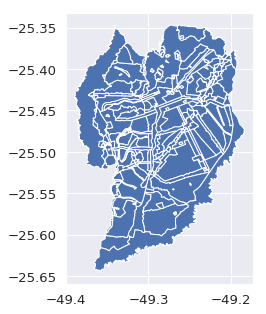

In [77]:
zone_shape.plot(figsize=(5, 5))

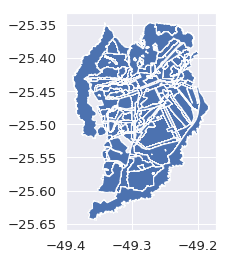

In [41]:
union_zone = gpd.sjoin(zone_shape, df_dna_geo, op='intersects')
union_zone.plot()

In [ ]:
%%time
ax = union_nbh.plot(figsize=(5,5), color='#EFEFEF', edgecolor='#444444')

In [100]:
union_nbh.NOME.unique()

array(['ÁGUA VERDE', 'JARDIM SOCIAL', 'XAXIM', 'JARDIM DAS AMÉRICAS',
       'GUAÍRA', 'BAIRRO ALTO', 'SÃO FRANCISCO', 'ALTO DA GLÓRIA',
       'ATUBA', 'CABRAL', 'LINDÓIA', 'CAMPO COMPRIDO', 'CENTRO CÍVICO',
       'JUVEVÊ', 'HUGO LANGE', 'CAPÃO DA IMBUIA', 'SEMINÁRIO',
       'GUABIROTUBA', 'PRADO VELHO', 'PAROLIN', 'PORTÃO', 'VILA IZABEL',
       'CAMPINA DO SIQUEIRA', 'BOA VISTA', 'AHÚ', 'CRISTO REI',
       'REBOUÇAS', 'ORLEANS', 'PILARZINHO', 'MOSSUNGUÊ', 'ALTO DA RUA XV',
       'JARDIM BOTÂNICO', 'BUTIATUVINHA', 'BARREIRINHA', 'TINGUI',
       'BOQUEIRÃO', 'SÍTIO CERCADO', 'TARUMÃ', 'SÃO LOURENÇO',
       'BACACHERI', 'BIGORRILHO', 'BOM RETIRO', 'CAPÃO RASO', 'HAUER',
       'FANNY', 'NOVO MUNDO', 'FAZENDINHA', 'SANTA QUITÉRIA', 'CENTRO',
       'ABRANCHES', 'BATEL', 'ALTO BOQUEIRÃO', 'PINHEIRINHO', 'TATUQUARA',
       'UMBARÁ', 'CAMPO DE SANTANA', 'GANCHINHO', 'CAJURU', 'UBERABA',
       'TABOÃO', 'CACHOEIRA', 'SANTA CÂNDIDA',
       'CIDADE INDUSTRIAL DE CURITIBA', 'LAMENHA P

In [103]:
df_dna_geo['neighborhood.name'] = df_dna_geo['neighborhood.name'].str.upper()

In [114]:
top_ads_by_nbh = df_dna_geo['neighborhood.name'].value_counts().to_frame()

In [115]:
top_ads_by_nbh.columns

Index(['neighborhood.name'], dtype='object')

CPU times: user 21.8 s, sys: 168 ms, total: 22 s
Wall time: 21.7 s


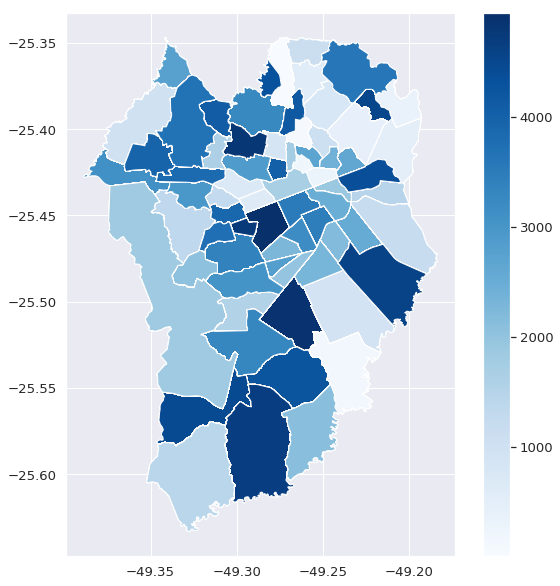

In [268]:
%%time
# fig, ax = plt.subplots(figsize = (30,25))
vmax, vmin = 4944, 3
ax = union_nbh.plot(figsize=(10, 10), column='NOME', cmap='Blues', k=5)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=ax)

# Value Analysis

## Heatmap Value

In [273]:
# df_dna_geo['neighborhood.name'] = df_dna_geo['neighborhood.name'].str.upper()
df_wo_sell['neighborhood.name'] = df_wo_sell['neighborhood.name'].str.upper()
heatmap_value = df_wo_sell.groupby(['neighborhood.name'], as_index=False).mean()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [290]:
geometry = [Point(xy) for xy in zip(heatmap_value['longitude'], heatmap_value['latitude'])]
heatmap_value = gpd.GeoDataFrame(heatmap_value, crs={'init':'epsg:4326'}, geometry=geometry)
union_nbh_value = gpd.sjoin(nbh_border_shape, heatmap_value, op='intersects')

In [311]:
nbh_border_shape['NOME'].unique()

array(['ÁGUA VERDE', 'JARDIM SOCIAL', 'XAXIM', 'JARDIM DAS AMÉRICAS',
       'GUAÍRA', 'BAIRRO ALTO', 'SÃO FRANCISCO', 'ALTO DA GLÓRIA',
       'ATUBA', 'CABRAL', 'LINDÓIA', 'CAMPO COMPRIDO', 'CENTRO CÍVICO',
       'JUVEVÊ', 'HUGO LANGE', 'CAPÃO DA IMBUIA', 'SEMINÁRIO',
       'GUABIROTUBA', 'PRADO VELHO', 'PAROLIN', 'PORTÃO', 'VILA IZABEL',
       'CAMPINA DO SIQUEIRA', 'BOA VISTA', 'AHÚ', 'CRISTO REI',
       'REBOUÇAS', 'ORLEANS', 'PILARZINHO', 'MOSSUNGUÊ', 'ALTO DA RUA XV',
       'JARDIM BOTÂNICO', 'BUTIATUVINHA', 'BARREIRINHA', 'TINGUI',
       'BOQUEIRÃO', 'RIVIERA', 'SÍTIO CERCADO', 'TARUMÃ', 'SÃO LOURENÇO',
       'BACACHERI', 'BIGORRILHO', 'BOM RETIRO', 'CAPÃO RASO', 'HAUER',
       'FANNY', 'NOVO MUNDO', 'FAZENDINHA', 'SANTA QUITÉRIA', 'CENTRO',
       'ABRANCHES', 'BATEL', 'SÃO MIGUEL', 'AUGUSTA', 'CAXIMBA',
       'ALTO BOQUEIRÃO', 'PINHEIRINHO', 'TATUQUARA', 'UMBARÁ',
       'CAMPO DE SANTANA', 'GANCHINHO', 'CAJURU', 'UBERABA', 'TABOÃO',
       'CACHOEIRA', 'SANTA CÂNDID

In [309]:
#VARGEM GRANDE
heatmap_value['neighborhood.name'].unique()

array(['ABRANCHES', 'AFONSO PENA - AEROPORTO', 'AHÚ',
       'ALPHAVILLE PINHAIS ', 'ALTO BOQUEIRÃO', 'ALTO DA GLÓRIA',
       'ALTO DA RUA XV', 'ATUBA', 'AUGUSTA', 'BACACHERI', 'BAIRRO ALTO',
       'BARREIRINHA', 'BATEL', 'BIGORRILHO', 'BOA VISTA', 'BOM RETIRO',
       'BOQUEIRÃO', 'BUTIATUVINHA', 'CABRAL', 'CACHOEIRA', 'CAJURU',
       'CAMPINA DO SIQUEIRA', 'CAMPO COMPRIDO', 'CAMPO DE SANTANA',
       'CAMPO PEQUENO', 'CAPELA VELHA', 'CAPÃO DA IMBUIA', 'CAPÃO RASO',
       'CASCATINHA', 'CASCAVEL VELHO', 'CASTELO BRANCO', 'CAXIMBA',
       'CENTRO', 'CENTRO CÍVICO', 'CIDADE INDUSTRIAL', 'CRISTO REI',
       'ESTÂNCIA PINHAIS', 'FANNY', 'FAZENDINHA', 'GANCHINHO',
       'GUABIROTUBA', 'GUAÍRA', 'HAUER', 'HUGO LANGE', 'JARDIM AMÉLIA',
       'JARDIM BOTÂNICO', 'JARDIM DAS AMÉRICAS', 'JARDIM SOCIAL',
       'JUVEVÊ', 'LAMENHA PEQUENA', 'LINDÓIA', 'MERCÊS', 'MOSSUNGUÊ',
       'NAÇÕES', 'NOVO MUNDO', 'ORLEANS', 'PAROLIN', 'PILARZINHO',
       'PINEVILLE', 'PINHEIRINHO', 'PORTÃO', 'PRAD

In [310]:
union_nbh_value['neighborhood.name'].unique()

array(['ÁGUA VERDE', 'JARDIM SOCIAL', 'XAXIM', 'JARDIM DAS AMÉRICAS',
       'GUAÍRA', 'BAIRRO ALTO', 'SÃO FRANCISCO', 'ALTO DA GLÓRIA',
       'ATUBA', 'CABRAL', 'LINDÓIA', 'CAMPO COMPRIDO', 'CENTRO CÍVICO',
       'JUVEVÊ', 'HUGO LANGE', 'CAPÃO DA IMBUIA', 'SEMINÁRIO',
       'GUABIROTUBA', 'PRADO VELHO', 'PAROLIN', 'PORTÃO', 'VILA IZABEL',
       'CAMPINA DO SIQUEIRA', 'BOA VISTA', 'AHÚ', 'CRISTO REI',
       'REBOUÇAS', 'ORLEANS', 'PILARZINHO', 'MOSSUNGUÊ', 'ALTO DA RUA XV',
       'JARDIM BOTÂNICO', 'BUTIATUVINHA', 'BARREIRINHA', 'TINGUI',
       'BOQUEIRÃO', 'RIVIERA', 'SÍTIO CERCADO', 'TARUMÃ', 'SÃO LOURENÇO',
       'BACACHERI', 'BIGORRILHO', 'BOM RETIRO', 'CAPÃO RASO', 'HAUER',
       'FANNY', 'NOVO MUNDO', 'FAZENDINHA', 'SANTA QUITÉRIA', 'CENTRO',
       'ABRANCHES', 'BATEL', 'SÃO MIGUEL', 'AUGUSTA', 'ALTO BOQUEIRÃO',
       'PINHEIRINHO', 'TATUQUARA', 'UMBARÁ', 'CAMPO DE SANTANA',
       'GANCHINHO', 'CAJURU', 'UBERABA', 'TABOÃO', 'CACHOEIRA',
       'SANTA CÂNDIDA', 'CIDADE

CPU times: user 152 ms, sys: 35.8 ms, total: 188 ms
Wall time: 85.3 ms


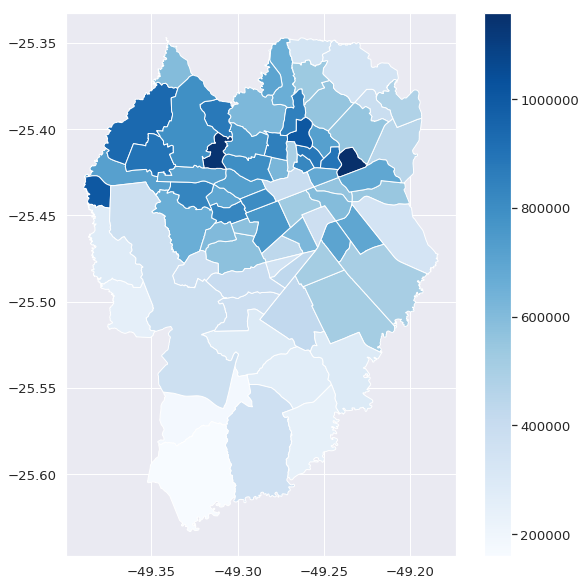

In [301]:
%%time
# fig, ax = plt.subplots(figsize = (30,25))
vmax, vmin = union_nbh_value.value.max(), union_nbh_value.value.min()

ax = union_nbh_value.plot(figsize=(10, 10), column='value', cmap='Blues')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=ax)

### Beware! Business Type

## Top 20 High price neighborhood by Sell and Rent

In [176]:
top_mean_price = df_wo_sell[['neighborhood.name', 'value']].groupby(['neighborhood.name'], as_index=False).mean()

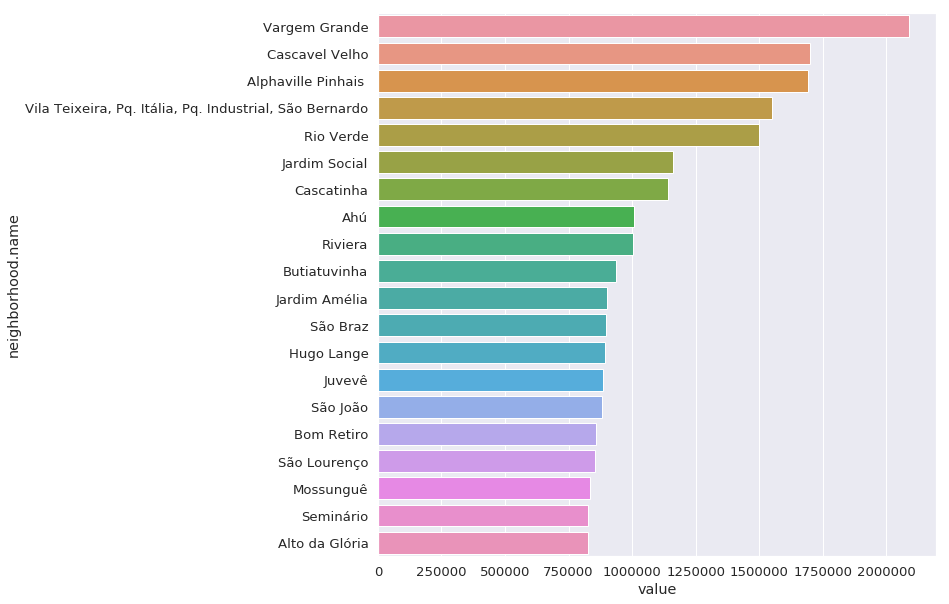

In [146]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x="value", y="neighborhood.name", data=top_mean_price.sort_values(by=('value'), ascending=False).head(20))

# Property Tax

In [318]:
df_prop_tax = df_ddp

In [319]:
df_prop_tax['z_value'] = np.abs((df_prop_tax['iptu'] - df_prop_tax['iptu'].mean())/df_prop_tax['iptu'].std(ddof=0))
df_wo_prop_tax = df_prop_tax[df_prop_tax['z_value'] < 1]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [316]:
df_selected.columns

Index(['advertiser.id', 'advertiser.name', 'area_total', 'area_util',
       'neighborhood.id', 'neighborhood.name', 'bathroom', 'city.full_name',
       'city.short_name', 'city_uf', 'code', 'condominium', 'date_inclusion',
       'default', 'description', 'address', 'error', 'goal', 'garage',
       'geohash', 'geometry.coordinates', 'geometry.type', 'iptu',
       'isparticular', 'isportal', 'latitude', 'photolist', 'longitude',
       'optional', 'bedroom', 'scraping.spider_name', 'status', 'suite',
       'property_type', 'business_type', 'title', 'uf', 'url', 'value',
       'zoning.id', 'zoning.name', 'zoning.initials'],
      dtype='object')

Text(0.5, 1.0, 'Property Tax Distribution - After')

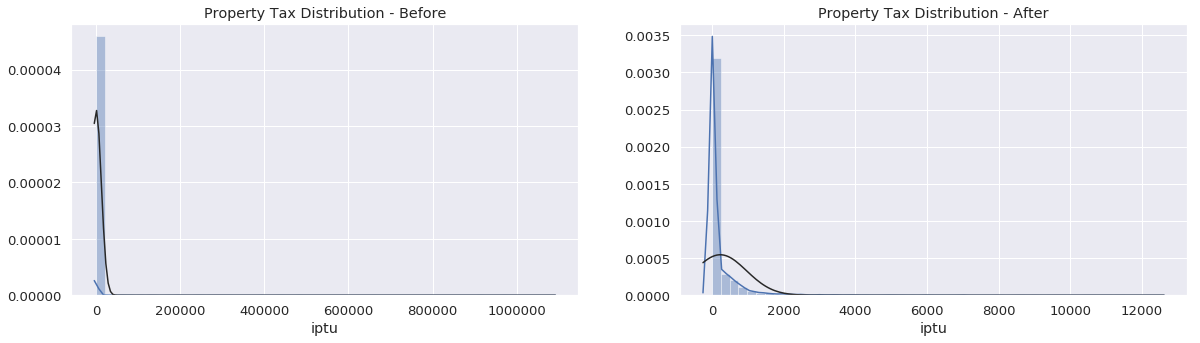

In [322]:
#[df_sell['value']<0.5*1e7]
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.set(font_scale=1.2)
sns.distplot(df_ddp['iptu'].dropna(), fit=norm, ax=ax[0]).set_title("Property Tax Distribution - Before")
sns.distplot(df_wo_prop_tax['iptu'].dropna(), fit=norm, ax=ax[1]).set_title("Property Tax Distribution - After")

In [325]:
heatmap_prop_tax = df_wo_prop_tax.groupby(['zoning.initials'], as_index=False).mean()

In [326]:
geometry = [Point(xy) for xy in zip(heatmap_prop_tax['longitude'], heatmap_prop_tax['latitude'])]
heatmap_prop_tax = gpd.GeoDataFrame(heatmap_prop_tax, crs={'init':'epsg:4326'}, geometry=geometry)
union_zone_prop_tax = gpd.sjoin(zone_shape, heatmap_prop_tax, op='intersects')

CPU times: user 105 ms, sys: 67.9 ms, total: 173 ms
Wall time: 75.5 ms


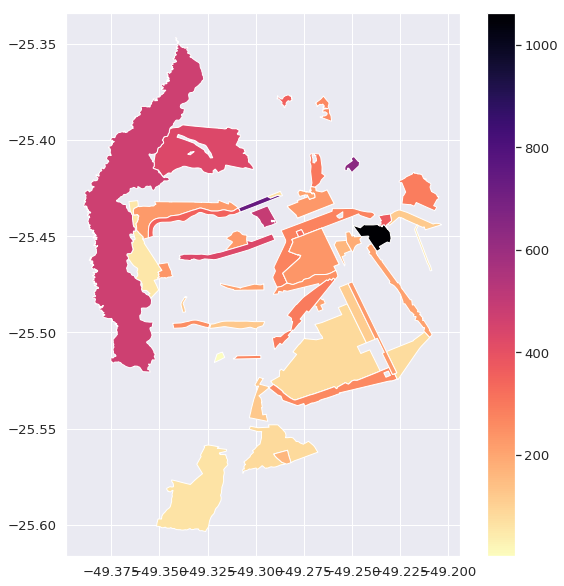

In [339]:
%%time
# fig, ax = plt.subplots(figsize = (30,25))
vmax, vmin = union_zone_prop_tax.iptu.max(), union_zone_prop_tax.iptu.min()

ax = union_zone_prop_tax.plot(figsize=(10, 10), column='iptu', cmap='magma_r')
sm = plt.cm.ScalarMappable(cmap='magma_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=ax)

In [337]:
heatmap_prop_tax.columns

Index(['zoning.initials', 'area_total', 'area_util', 'bathroom', 'condominium',
       'garage', 'iptu', 'isparticular', 'isportal', 'latitude', 'longitude',
       'bedroom', 'status', 'suite', 'value', 'z_value', 'geometry'],
      dtype='object')

In [207]:
plt.figure(figsize=(10, 20))
ax = sns.barplot(x="iptu", y="zoning.initials", data=heatmap_prop_tax.sort_values(by=('iptu'), ascending=False))

NameError: name 'heatmap_prop_tax' is not defined

<Figure size 720x1440 with 0 Axes>

# Cleansing and Save Data for Factore Analysis

Text(0.5, 1.0, 'Area Util Distribution')

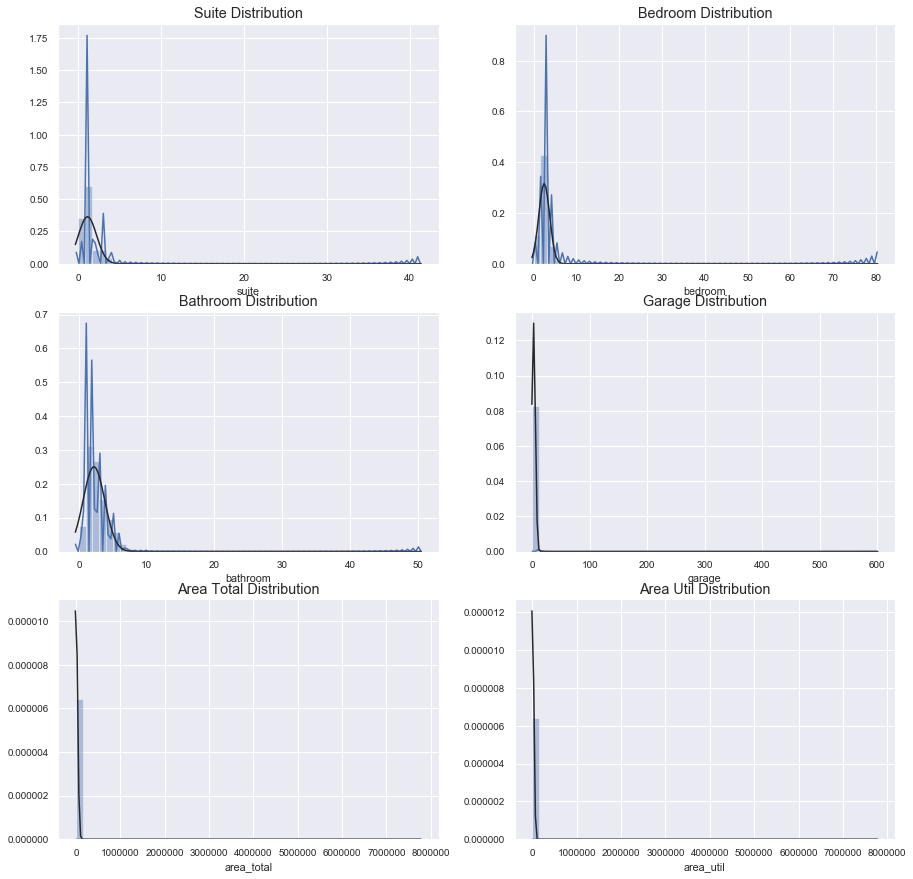

In [25]:
fig, ax = plt.subplots(3,2, figsize=(15, 15))
sns.set(font_scale=1.2)
sns.distplot(df_ddp['suite'].dropna(), fit=norm, ax=ax[0][0]).set_title("Suite Distribution") 
sns.distplot(df_ddp['bedroom'].dropna(), fit=norm, ax=ax[0][1]).set_title("Bedroom Distribution")
sns.distplot(df_ddp['bathroom'].dropna(), fit=norm, ax=ax[1][0]).set_title("Bathroom Distribution")
sns.distplot(df_ddp['garage'].dropna(), fit=norm, ax=ax[1][1]).set_title("Garage Distribution")
sns.distplot(df_ddp['area_total'].dropna(), fit=norm, ax=ax[2][0]).set_title("Area Total Distribution")
sns.distplot(df_ddp['area_util'].dropna(), fit=norm, ax=ax[2][1]).set_title("Area Util Distribution")

In [26]:
df_pfa = df_ddp[['suite','bedroom','bathroom','garage','area_total','area_util','value']]

In [27]:
df_pfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92247 entries, 0 to 149961
Data columns (total 7 columns):
suite         56262 non-null float64
bedroom       86033 non-null float64
bathroom      65055 non-null float64
garage        81263 non-null float64
area_total    57733 non-null float64
area_util     68391 non-null float64
value         91364 non-null float64
dtypes: float64(7)
memory usage: 5.6 MB


In [28]:
df_pfa.fillna(0, inplace=True)

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [29]:
df_pfa.isnull().sum()/len(df_pfa) * 100

suite         0.0
bedroom       0.0
bathroom      0.0
garage        0.0
area_total    0.0
area_util     0.0
value         0.0
dtype: float64

In [31]:
df_sell = df_ddp[df_ddp['business_type'] == 'Venda']

df_sell['z_value'] = np.abs((df_sell['value'] - df_sell['value'].mean())/df_sell['value'].std(ddof=0))
df_wo_sell = df_sell[df_sell['z_value'] < 1]

df_pfa = df_wo_sell[['suite','bedroom','bathroom','garage','area_total','area_util','value']]
df_pfa = df_pfa.fillna(0)

df_pfa['z_value_suite'] = np.abs((df_pfa['suite'] - df_pfa['suite'].mean())/df_pfa['suite'].std(ddof=0))
df_pfa = df_pfa[df_pfa['z_value_suite'] < 1]

df_pfa['z_value_bedroom'] = np.abs((df_pfa['bedroom'] - df_pfa['bedroom'].mean())/df_pfa['bedroom'].std(ddof=0))
df_pfa = df_pfa[df_pfa['z_value_bedroom'] < 1]

df_pfa['z_value_bathroom'] = np.abs((df_pfa['bathroom'] - df_pfa['bathroom'].mean())/df_pfa['bathroom'].std(ddof=0))
df_pfa = df_pfa[df_pfa['z_value_bathroom'] < 1]

df_pfa['z_value_garage'] = np.abs((df_pfa['garage'] - df_pfa['garage'].mean())/df_pfa['garage'].std(ddof=0))
df_pfa = df_pfa[df_pfa['z_value_garage'] < 1]

df_pfa['z_value_area_total'] = np.abs((df_pfa['area_total'] - df_pfa['area_total'].mean())/df_pfa['area_total'].std(ddof=0))
df_pfa = df_pfa[df_pfa['z_value_area_total'] < 1]

df_pfa['z_value_area_util'] = np.abs((df_pfa['area_util'] - df_pfa['area_util'].mean())/df_pfa['area_util'].std(ddof=0))
df_pfa = df_pfa[df_pfa['z_value_area_util'] < 1]


df_pfa = df_pfa.drop(['z_value_suite', 'z_value_bedroom', 'z_value_bathroom', 'z_value_garage', 'z_value_area_total', 'z_value_area_util'], axis=1)
df_pfa = df_pfa[df_pfa['area_total'] > 0]

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
df_ddp[['suite','bedroom','bathroom','garage','area_total','area_util','value']].describe()

,suite,bedroom,bathroom,garage,area_total,area_util,value
count,56262.000000,86033.000000,65055.000000,81263.000000,5.773300e+04,6.839100e+04,9.136400e+04
mean,1.094593,2.479211,2.216371,1.921416,6.631593e+02,3.972375e+02,6.570301e+05
std,1.094596,1.261653,1.591466,3.069379,3.581292e+04,3.124229e+04,1.263453e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+02
25%,0.000000,2.000000,1.000000,1.000000,8.000000e+01,5.700000e+01,1.999000e+05
50%,1.000000,3.000000,2.000000,2.000000,1.430000e+02,8.900000e+01,3.890000e+05
75%,1.000000,3.000000,3.000000,2.000000,2.780000e+02,1.650000e+02,7.500000e+05
max,41.000000,80.000000,50.000000,600.000000,7.774000e+06,7.774000e+06,1.111111e+08


In [33]:
df_pfa.describe()

,suite,bedroom,bathroom,garage,area_total,area_util,value
count,13581.000000,13581.000000,13581.000000,13581.000000,13581.000000,13581.000000,1.358100e+04
mean,0.589279,2.462853,1.581400,1.247552,98.451395,68.773958,3.466870e+05
std,0.491983,0.498637,0.493348,0.431606,36.107331,16.246455,1.554895e+05
min,0.000000,2.000000,1.000000,1.000000,7.000000,34.000000,3.200000e+04
25%,0.000000,2.000000,1.000000,1.000000,71.000000,56.000000,2.300000e+05
50%,1.000000,2.000000,2.000000,1.000000,95.000000,67.000000,3.150000e+05
75%,1.000000,3.000000,2.000000,1.000000,120.000000,80.000000,4.411010e+05
max,1.000000,3.000000,2.000000,2.000000,360.000000,107.000000,1.189500e+06


NameError: name 'df_pfa' is not defined

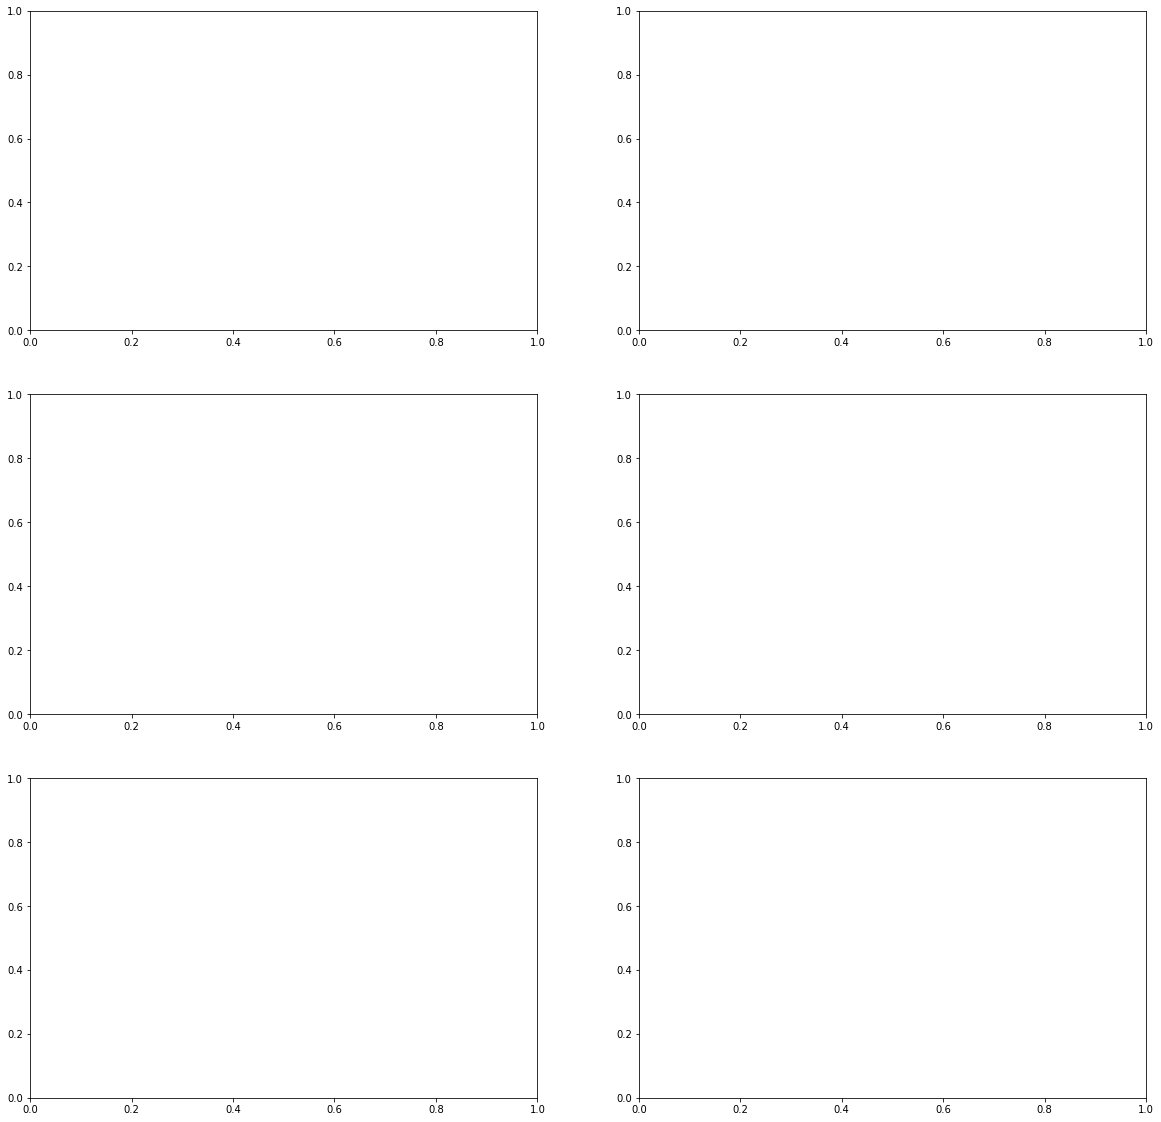

In [12]:
fig, ax = plt.subplots(3,2, figsize=(20, 20))
sns.distplot(df_pfa['suite'], fit=norm, ax=ax[0][0]).set_title("Suite Distribution") 
sns.distplot(df_pfa['bedroom'], fit=norm, ax=ax[0][1]).set_title("Bedroom Distribution")
sns.distplot(df_pfa['bathroom'], fit=norm, ax=ax[1][0]).set_title("Bathroom Distribution")
sns.distplot(df_pfa['garage'], fit=norm, ax=ax[1][1]).set_title("Garage Distribution")
sns.distplot(df_pfa['area_total'], fit=norm, ax=ax[2][0]).set_title("Area Total Distribution")
sns.distplot(df_pfa['area_util'], fit=norm, ax=ax[2][1]).set_title("Area Util Distribution")

In [192]:
df_pfa.isnull().sum()

suite         0
bedroom       0
bathroom      0
garage        0
area_total    0
area_util     0
value         0
dtype: int64

Text(0.5, 1.0, 'Value Distribution - Before Cut Outlier')

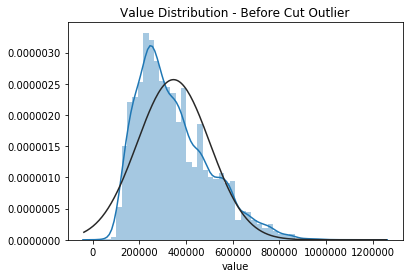

In [82]:
## Plot Value Distribution
sns.distplot(df_pfa['value'], fit=norm).set_title("Value Distribution - Before Cut Outlier")

In [83]:
# df_pfa.to_excel('./ads_sell.xlsx')
df_pfa.shape

(13581, 7)

## Dimension Reduction with PCA

In [34]:
from sklearn.preprocessing import StandardScaler
norm = StandardScaler()
norm_data = norm.fit_transform(df_pfa.drop(['value'], axis=1))

In [35]:
norm_data = pd.DataFrame(norm_data, columns=df_pfa.drop(['value'], axis=1).columns)

In [42]:
norm_data.head(5)

,suite,bedroom,bathroom,garage,area_total,area_util
0,0.834858,-0.92827,-1.178524,-0.573581,-0.649515,-1.032507
1,-1.197808,-0.92827,-1.178524,-0.573581,-1.231136,-1.278723
2,-1.197808,-0.92827,-1.178524,-0.573581,-0.566426,-1.401832
3,-1.197808,-0.92827,-1.178524,-0.573581,-0.594123,-1.340278
4,-1.197808,-0.92827,-1.178524,-0.573581,-1.314225,-1.463386


In [36]:
from sklearn.model_selection import train_test_split
y = df_pfa['value']
X_train, X_test, y_train, y_test = train_test_split(norm_data, y, test_size=0.3, random_state=12)

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_model = pca.fit(X_train)

In [38]:
pca_train = pca_model.transform(X_train)
pca_test = pca_model.transform(X_test)

In [39]:
matrix = pd.DataFrame(pca_model.components_, columns=df_pfa.drop(['value'], axis=1).columns)
matrix1 = np.transpose(matrix)

In [40]:
print(matrix1)
print(pca_model.explained_variance_)
var = pca_model.explained_variance_ratio_

                   0         1         2
suite       0.432906 -0.515831 -0.030745
bedroom     0.309691  0.438126 -0.750586
bathroom    0.435024 -0.515340 -0.022644
garage      0.318072  0.459268  0.621174
area_total  0.449483  0.151496  0.208777
area_util   0.473532  0.206180 -0.075622
[3.18200718 0.98607555 0.77486356]


Text(0, 0.5, 'Cumulative Proportion of Variance Explained')

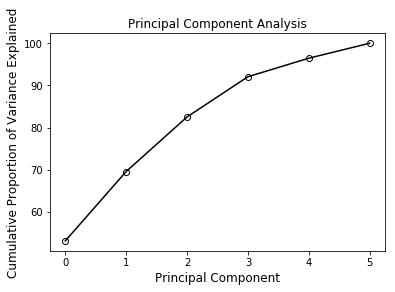

In [113]:
cumulative_var = np.cumsum(np.round(var, decimals=4)*100)
plt.plot(cumulative_var,'k-o',markerfacecolor='None',markeredgecolor='k')
plt.title('Principal Component Analysis',fontsize=12)
plt.xlabel("Principal Component",fontsize=12)
plt.ylabel("Cumulative Proportion of Variance Explained",fontsize=12)

In [163]:
## Create Train Data
pca_train = pd.DataFrame(pca_train, columns=['PC_' + str(i) for i in range(1, 4)])
y_train1 = y_train.reset_index()
pca_train1 = pd.concat([pca_train, y_train1], axis=1)
pca_train2 = pca_train1.drop(columns='index')
pca_train3 = pca_train1[['PC_1', 'PC_2', 'PC_3', 'value']]

In [164]:
pca_train_X = pca_train3[['PC_1', 'PC_2', 'PC_3']]

In [165]:
from sklearn.linear_model import LinearRegression
linreg_model = LinearRegression()
linreg_model.fit(pca_train_X, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [167]:
## Create Test Data
pca_test = pd.DataFrame(pca_test, columns=['PC_' + str(i) for i in range(1, 4)])
y_test1 = y_test.reset_index()
pca_test1 = pd.concat([pca_test, y_test1], axis=1)
pca_test2 = pca_test1.drop(columns='index')
pca_test3 = pca_test1[['PC_1', 'PC_2', 'PC_3', 'value']]

In [168]:
pca_test_X = pca_test3[['PC_1', 'PC_2', 'PC_3']]

In [169]:
predict1 = linreg_model.predict(pca_test_X)

In [170]:
from sklearn import metrics
metrics.r2_score(y_test, predict1)

0.6151041711662519

## Compare r2 score with PCA by use PFA

In [45]:
norm = StandardScaler()
norm_data = norm.fit_transform(df_pfa.drop(['value'], axis=1))
norm_data = pd.DataFrame(norm_data, columns=df_pfa.drop(['value'], axis=1).columns)
norm_data = norm_data[['bathroom', 'area_total', 'area_util']]

y = df_pfa['value']
X_train, X_test, y_train, y_test = train_test_split(norm_data, y, test_size=0.3, random_state=12)

In [47]:
norm_data.head(5)

,bathroom,area_total,area_util
0,-1.178524,-0.649515,-1.032507
1,-1.178524,-1.231136,-1.278723
2,-1.178524,-0.566426,-1.401832
3,-1.178524,-0.594123,-1.340278
4,-1.178524,-1.314225,-1.463386


In [174]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [175]:
predict_pfa = linreg_model.predict(X_test)

In [176]:
from sklearn import metrics
metrics.r2_score(y_test, predict_pfa)

0.5862998802114275